In [1]:
from __future__ import division, unicode_literals, print_function  
import numpy as np
import matplotlib.pyplot as plt
import pims  # image reading routines
import os

import pandas as pd
#from pandas import DataFrame, Series  

import trackpy as tp
from scipy import ndimage  # for shifting images
from pims import pipeline
from pims import Frame
from scipy.interpolate import griddata  # for resampling
import matplotlib.patches as mpatches   # circles
from scipy.signal import savgol_filter
from skimage.transform import rotate


#%load_ext autoreload
#%autoreload 2

#from track_lib import  *

from scipy.optimize import curve_fit
# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)


#Acceleration integrator
def find_baseline(channel):
    sum = 0
    for i in range(10000):
        sum += channel[i]
    return sum/10000

conv = 1#981/0.3 #should this be 0.55?

def integrate_accel(channel, Time):
    baseline = find_baseline(channel)
    velocity = np.zeros(Time.size)
    running_sum = 0
    for i in range(Time.size-1):
        dv = 0.5*(conv*(channel[i]-baseline)+(channel[i+1]-baseline))*(Time[i+1]-Time[i])
        running_sum += dv
        velocity[i] = running_sum
    velocity[i+1] = running_sum
    return velocity

def sub_integrate_vel(channel, lower, higher, Time):
    baseline = find_baseline(channel)
    velocity = np.zeros(Time.size)
    running_sum = 0
    for i in range(lower, higher):
        dv = 0.5*((channel[i]-baseline)+(channel[i+1]-baseline))*(Time[i+1]-Time[i])
        running_sum += dv
        velocity[i] = running_sum
    velocity[i+1] = running_sum
    return velocity

def differentiate(data, f_p_s):
    dx = np.zeros(data.size)
    for i in range(dx.size-1):
        dx[i] = (data[i+1]-data[i])*f_p_s
    return dx


In [2]:
#load data, channel A at 8cm, B at 10cm, C at 12cm, D at 14cm
accel_xdata1 = pd.read_csv('SZ0-ax.csv')
accel_ydata1 = pd.read_csv('SZ0-ay.csv')

accel_xdata2 = pd.read_csv('SZ0-bx.csv')
accel_ydata2 = pd.read_csv('SZ0-by.csv')

accel_xdata3 = pd.read_csv('SZ0-cx.csv')
accel_ydata3 = pd.read_csv('SZ0-cy.csv')

In [3]:
accel_xdata1

,Time,Channel A,Channel B,Channel C,Channel D,Channel H
0,(ms),(V),(V),(V),(V),(V)
1,-99.99298304,1.60862500,1.59351700,1.60435200,1.59565400,7.13313400
2,-99.98298304,1.61122000,1.59351700,1.60175800,1.59565400,7.13313400
3,-99.97298304,1.60862500,1.59611200,1.60435200,1.59565400,7.13862800
4,-99.96298304,1.61122000,1.59351700,1.60709900,1.59840100,7.12764000
...,...,...,...,...,...,...
100000,899.99699169,1.61122000,1.59611200,1.60709900,1.59290700,7.13313400
100001,900.00699169,1.60862500,1.59351700,1.60435200,1.59565400,7.13313400
100002,900.01699169,1.60862500,1.59351700,1.60435200,1.59290700,7.13313400
100003,900.02699169,1.61122000,1.59611200,1.60709900,1.59565400,7.13862800


In [4]:
Timex = np.zeros(accel_xdata1.loc[1:,"Time"].size)
Timex[:] = np.array(accel_xdata1.loc[1:,"Time"])
Timex = Timex/1000

Accel_data = np.zeros((2,3,4,accel_xdata1.loc[1:,"Time"].size)) #x or y, 3 datasets, 4 channels, data for each cannel

#load x data
Accel_data[0,0,0,:] = np.array(accel_xdata1.loc[1:,"Channel A"])
Accel_data[0,0,1,:] = np.array(accel_xdata1.loc[1:,"Channel B"])
Accel_data[0,0,2,:] = np.array(accel_xdata1.loc[1:,"Channel C"])
Accel_data[0,0,3,:] = np.array(accel_xdata1.loc[1:,"Channel D"])

Accel_data[0,1,0,:] = np.array(accel_xdata2.loc[1:,"Channel A"])
Accel_data[0,1,1,:] = np.array(accel_xdata2.loc[1:,"Channel B"])
Accel_data[0,1,2,:] = np.array(accel_xdata2.loc[1:,"Channel C"])
Accel_data[0,1,3,:] = np.array(accel_xdata2.loc[1:,"Channel D"])

Accel_data[0,2,0,:] = np.array(accel_xdata3.loc[1:,"Channel A"])
Accel_data[0,2,1,:] = np.array(accel_xdata3.loc[1:,"Channel B"])
Accel_data[0,2,2,:] = np.array(accel_xdata3.loc[1:,"Channel C"])
Accel_data[0,2,3,:] = np.array(accel_xdata3.loc[1:,"Channel D"])

#load y data
Accel_data[1,0,0,:] = np.array(accel_ydata1.loc[1:,"Channel A"])
Accel_data[1,0,1,:] = np.array(accel_ydata1.loc[1:,"Channel B"])
Accel_data[1,0,2,:] = np.array(accel_ydata1.loc[1:,"Channel C"])
Accel_data[1,0,3,:] = np.array(accel_ydata1.loc[1:,"Channel D"])

Accel_data[1,1,0,:] = np.array(accel_ydata2.loc[1:,"Channel A"])
Accel_data[1,1,1,:] = np.array(accel_ydata2.loc[1:,"Channel B"])
Accel_data[1,1,2,:] = np.array(accel_ydata2.loc[1:,"Channel C"])
Accel_data[1,1,3,:] = np.array(accel_ydata2.loc[1:,"Channel D"])

Accel_data[1,2,0,:] = np.array(accel_ydata3.loc[1:,"Channel A"])
Accel_data[1,2,1,:] = np.array(accel_ydata3.loc[1:,"Channel B"])
Accel_data[1,2,2,:] = np.array(accel_ydata3.loc[1:,"Channel C"])
Accel_data[1,2,3,:] = np.array(accel_ydata3.loc[1:,"Channel D"])

In [5]:
#Converting from volts to cm/s/s, remember that channel D is 3 g
Accel_data[0,:,:,:] = Accel_data[0,:,:,:]-1.6
Accel_data[1,:,0:2,:] = Accel_data[1,:,0:2,:]-1.66
Accel_data[1,:,3,:] = Accel_data[1,:,3,:]-1.9
#Making 3g scaled to 16 g voltage
Accel_data[:,:,3,:] = Accel_data[:,:,3,:]/5

Accel_data[:,:,:,:] = ((Accel_data[:,:,:,:])*(981/0.06))

In [6]:
Vel = np.zeros((2,3,4,accel_xdata1.loc[1:,"Time"].size))
for i in range(2):
    for j in range(3):
        for k in range(4):
            Vel[i,j,k,:] = integrate_accel(Accel_data[i,j,k,:], Timex)

(0.0, 60.0)

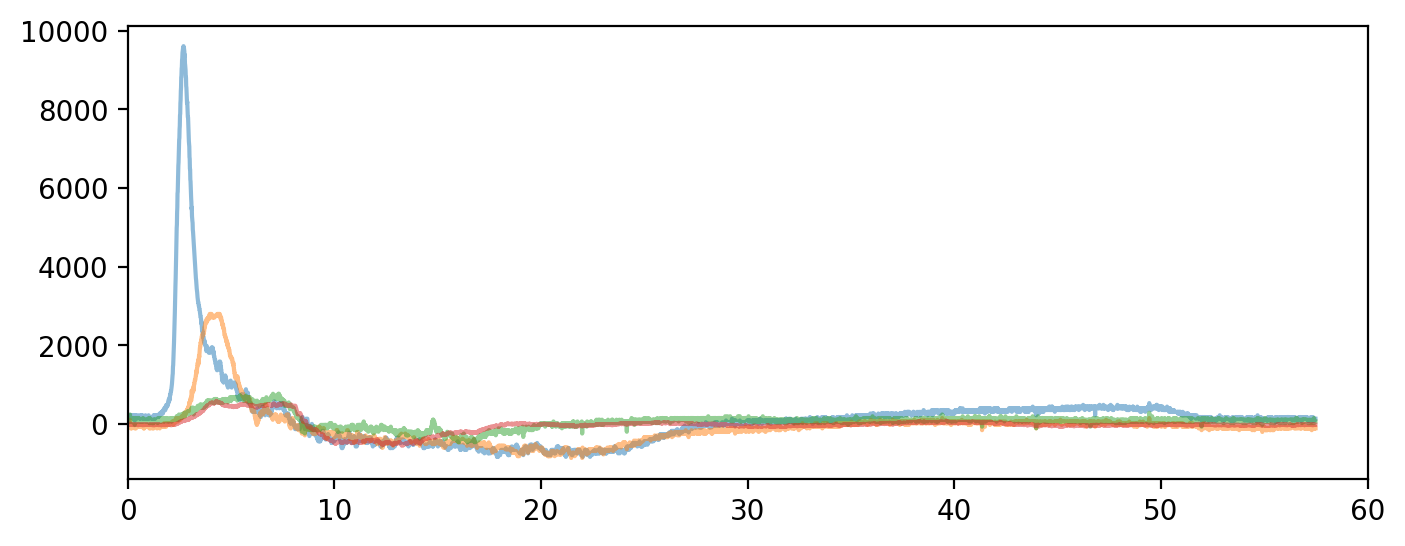

In [7]:
start = 20000
end = 30000
plt.figure(figsize=(8,3),dpi=200); 
for i in range(4):
    plt.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data[0,0,i,start:end]-1.6, alpha = 0.5)
plt.xlim(0,60)

(0.0, 60.0)

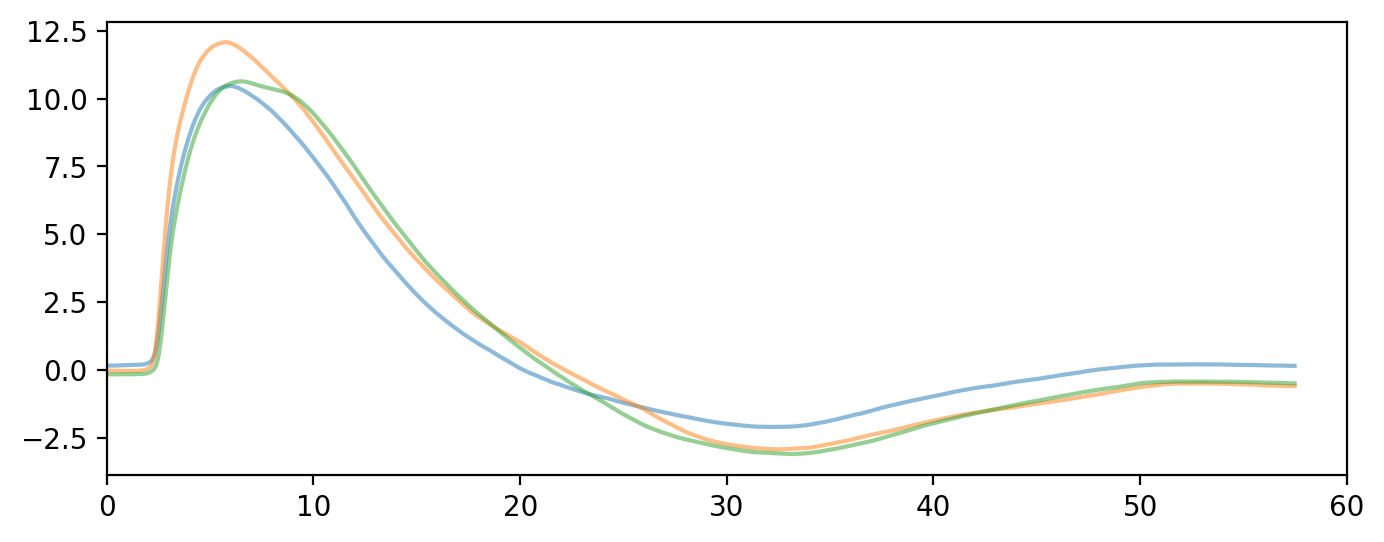

In [8]:
start = 20000
end = 30000
plt.figure(figsize=(8,3),dpi=200); 
plt.plot((Timex[start:end]-.13237)*1000-10.15,Vel[1,0,0,start:end]+0.1, alpha = 0.5)
for i in range(1,3):
    plt.plot((Timex[start:end]-.13237)*1000-10.15,Vel[1,i,0,start:end], alpha = 0.5)
plt.xlim(0,60)

In [9]:
Timex[30000] #30,000 is end index

0.20000700938

In [10]:
def peak_pos(pulse):
    peak = np.amax(pulse[:])
    return peak

In [11]:
peak_vel = np.zeros((2,2,3,4)) #radial position or peak vel, x or y, experiment, channel
#entering radial position
peak_vel[0,:,:,0] = 8
peak_vel[0,:,:,1] = 10
peak_vel[0,:,:,2] = 12
peak_vel[0,:,:,3] = 14
for i in range(2):
    for j in range(3):
        for k in range(4):
            peak_vel[1,i,j,k] = peak_pos(Vel[i,j,k,start:end]/100)

In [12]:
peak_vel

array([[[[ 8.        , 10.        , 12.        , 14.        ],
         [ 8.        , 10.        , 12.        , 14.        ],
         [ 8.        , 10.        , 12.        , 14.        ]],

        [[ 8.        , 10.        , 12.        , 14.        ],
         [ 8.        , 10.        , 12.        , 14.        ],
         [ 8.        , 10.        , 12.        , 14.        ]]],


       [[[ 0.10853541,  0.06311103,  0.028033  ,  0.0246445 ],
         [ 0.120304  ,  0.07385392,  0.0364581 ,  0.01739718],
         [ 0.09938575,  0.05258131,  0.03684919,  0.02589037]],

        [[ 0.10362959,  0.05166108,  0.03201168,  0.01933304],
         [ 0.12081076,  0.06159382,  0.03276404,  0.01834217],
         [ 0.10635178,  0.05569894,  0.0336869 ,  0.02014515]]]])

In [13]:
peak_vel_datax = np.zeros((12,2)) #radial or peak position, 12 accelerometers
peak_vel_datay = np.zeros((12,2)) #radial or peak position, 12 accelerometers

for i in range(2):
    for j in range(3):
        for k in range(4):
            peak_vel_datax[4*j + k, i] = peak_vel[i,0,j,k]
            peak_vel_datay[4*j + k, i] = peak_vel[i,1,j,k]

ValueError: s must be a scalar, or the same size as x and y

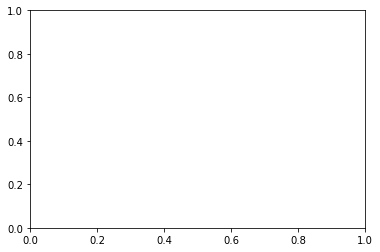

In [17]:
plt.scatter(peak_vel_datay[:,0], peak_vel_datay[:,1],(Timex[start:end]-.13237)*1000-10.15)
plt.yscale('log')

In [49]:
df = pd.DataFrame(peak_vel_datax, columns = ['init_pos','peak_vel'])
df2 = pd.DataFrame(peak_vel_datay, columns = ['init_pos','peak_vel'])

df.to_csv("SZ0_xvel.csv", index = True)
df2.to_csv("SZ0_yvel.csv", index = True)